In [1]:
import scipy.io
import numpy as np
from theano import config
from sklearn import preprocessing

mat = scipy.io.loadmat('data/mackeyglass.mat')
x = np.array(preprocessing.MinMaxScaler(feature_range=(0.1, 0.9)).fit_transform(mat['X']), config.floatX)
n = 112
m = n + 500
y_train = x[n+6:m+6]
x_0 = x[n:m]
x_6 = x[n-6:m-6]
x_12 = x[n-12:m-12]
x_18 = x[n-18:m-18]
X_train = np.hstack((x_0, x_6, x_12, x_18))

n = m + 1
m = n + 500
y_test = x[n+6:m+6]
x_0 = x[n:m]
x_6 = x[n-6:m-6]
x_12 = x[n-12:m-12]
x_18 = x[n-18:m-18]
X_test = np.hstack((x_0, x_6, x_12, x_18))

<IPython.core.display.Javascript object>


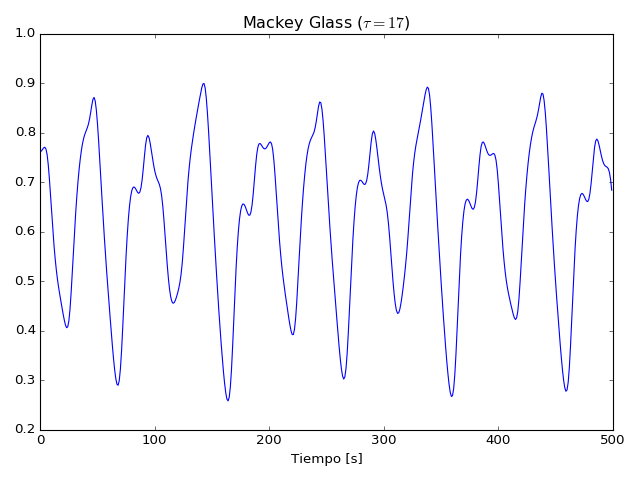

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

t = np.linspace(0, 499, 500)
plt.plot(t, X_train[:,0])
plt.title('Mackey Glass ($\\tau=17$)')
plt.xlabel('Tiempo [s]')
plt.tight_layout()

In [3]:
import sys
import os
sys.path.insert(0, os.path.abspath('../../../'))

from deepensemble.utils.utils_functions import ActivationFunctions
from deepensemble.models.sequential import Sequential
from deepensemble.layers.dense import Dense
from deepensemble.models.ensemblemodel import EnsembleModel
from deepensemble.combiner import *
from deepensemble.metrics import *
from deepensemble.utils import *

n_neurons = 48
n_models = 5
lr = 0.0005
batch_size = 15
max_epoch = 500
fn_activation1 = ActivationFunctions.tanh
fn_activation2 = ActivationFunctions.sigmoid

In [4]:
# Create Ensemble
ensemble = EnsembleModel(name="Ensemble")

# Create models for ensemble
for i in range(n_models):
    net = Sequential("net%d_ens" % i)  # by default is a regressor
    net.add_layer(Dense(n_input=X_train.shape[1], n_output=n_neurons, activation=fn_activation1))
    net.add_layer(Dense(n_output=y_train.shape[1], activation=fn_activation1))
    net.append_cost(mse, name='MSE')
    net.set_update(sgd, name='SGD', learning_rate=lr)
    ensemble.append_model(net)

ensemble.set_combiner(AverageCombiner())
ensemble.compile(fast=True)

metrics_ensemble = FactoryMetrics.get_metric(ensemble)
                      
# training
metrics = ensemble.fit(X_train, y_train, max_epoch=max_epoch, batch_size=batch_size)
print("FINISHED!")

# Compute metricstrain
metrics_ensemble.append_metric(metrics)

Start Compile Ensemble  - elapsed: 3.17 [s]
Ensemble - fold: 1, epoch:[####................] 100/500 elapsed: 1.09[s] - left: 4.31[s] | score: 0.0042 / 0.0068
FINISHED!


In [5]:
# Create Ensemble NCL
ensembleNCL = EnsembleModel(name="Ensemble")

# Create models for ensemble
for i in range(n_models):
    net = Sequential("net%d_ens" % i)  # by default is a regressor
    net.add_layer(Dense(n_input=X_train.shape[1], n_output=n_neurons, activation=fn_activation1))
    net.add_layer(Dense(n_output=y_train.shape[1], activation=fn_activation1))
    net.append_cost(mse, name='MSE')
    net.set_update(sgd, name='SGD', learning_rate=lr)
    ensembleNCL.append_model(net)

ensembleNCL.add_cost_ensemble(fun_cost=neg_corr, name="NEG_CORR", lamb=0.2)
ensembleNCL.set_combiner(AverageCombiner())
ensembleNCL.compile(fast=True)

metrics_ensembleNCL = FactoryMetrics.get_metric(ensembleNCL)
                      
# training
metrics = ensembleNCL.fit(X_train, y_train, max_epoch=max_epoch, batch_size=batch_size)
print("FINISHED!")

# Compute metricstrain
metrics_ensembleNCL.append_metric(metrics)

Start Compile Ensemble  - elapsed: 5.69 [s]
Ensemble - fold: 1, epoch:[####................] 100/500 elapsed: 1.23[s] - left: 4.87[s] | score: 0.0042 / 0.0068
FINISHED!


In [6]:
# Create MLP

mlp = Sequential("MLP")  # by default is a regressor
mlp.add_layer(Dense(n_input=X_train.shape[1], n_output=n_neurons*n_neurons, activation=fn_activation1))
mlp.add_layer(Dense(n_output=y_train.shape[1], activation=fn_activation1))
mlp.append_cost(mse, name='MSE')
mlp.set_update(sgd, name='SGD', learning_rate=lr)

mlp.compile(fast=True)

metrics_mlp = FactoryMetrics.get_metric(mlp)
                      
# training
metrics = mlp.fit(X_train, y_train, max_epoch=max_epoch, batch_size=batch_size)
print("FINISHED!")

# Compute metricstrain
metrics_mlp.append_metric(metrics)

Start Compile MLP  - elapsed: 0.40 [s]
MLP - fold: 1, epoch:[####################] 500/500 elapsed: 18.60[s] - left: 0.00[s] | score: 0.0115 / 0.0087
FINISHED!


In [53]:
# Create Ensemble KLG
ensembleKLG = EnsembleModel(name="Ensemble")

# Create models for ensemble
for i in range(n_models):
    net = Sequential("net%d_ens" % i)  # by default is a regressor
    net.add_layer(Dense(n_input=X_train.shape[1], n_output=n_neurons, activation=fn_activation1))
    net.add_layer(Dense(n_output=y_train.shape[1], activation=fn_activation2))
    # net.append_cost(cip_relevancy, name="CIP Relevancy")
    net.set_update(sgd, name='SGD', learning_rate=lr)
    ensembleKLG.append_model(net)

ensembleKLG.append_cost(fun_cost=cip_full, name="CIP Full", s=None, dist='ED-CIP')
ensembleKLG.set_combiner(AverageCombiner())
ensembleKLG.compile(fast=True)

metrics_ensembleKLG = FactoryMetrics.get_metric(ensembleKLG)
                      
# training
metrics = ensembleKLG.fit(X_train, y_train, max_epoch=max_epoch, batch_size=batch_size, early_stop=False)
print("FINISHED!")

# Compute metricstrain
metrics_ensembleKLG.append_metric(metrics)

Start Compile Ensemble  - elapsed: 7.39 [s]
Ensemble - fold: 1, epoch:[####################] 500/500 elapsed: 11.28[s] - left: 0.00[s] | score: 0.0274 / 0.0269
FINISHED!


<IPython.core.display.Javascript object>


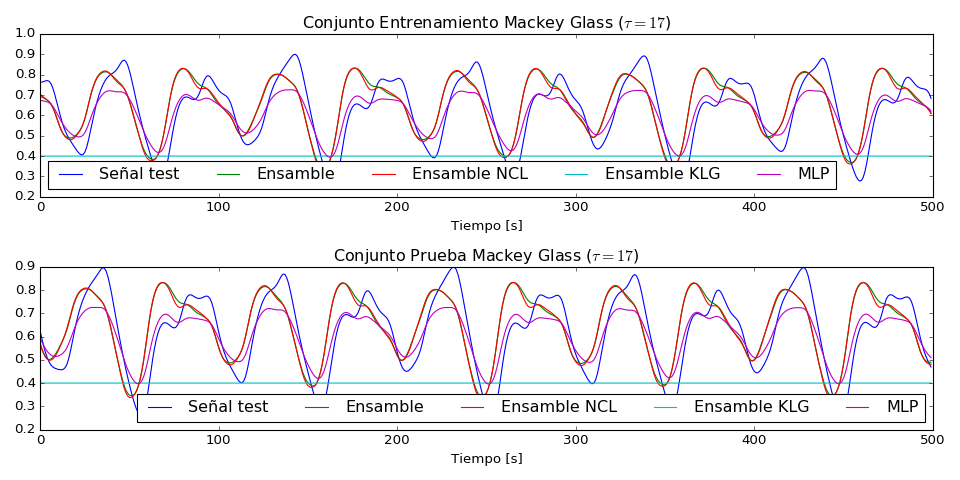

In [54]:
fig = plt.figure(figsize=(12, 6), dpi=80)

t = np.linspace(0, 499, 500)
plt.subplot(211)
plt.plot(t, X_train[:,0], label='Señal test')
plt.plot(t, ensemble.predict(X_train), label='Ensamble')
plt.plot(t, ensembleNCL.predict(X_train), label='Ensamble NCL')
plt.plot(t, ensembleKLG.predict(X_train), label='Ensamble KLG')
plt.plot(t, mlp.predict(X_train), label='MLP')
plt.title('Conjunto Entrenamiento Mackey Glass ($\\tau=17$)')
plt.xlabel('Tiempo [s]')
plt.legend(loc='best', ncol=5)

plt.subplot(212)
plt.plot(t, X_test[:,0], label='Señal test')
plt.plot(t, ensemble.predict(X_test), label='Ensamble')
plt.plot(t, ensembleNCL.predict(X_test), label='Ensamble NCL')
plt.plot(t, ensembleKLG.predict(X_test), label='Ensamble KLG')
plt.plot(t, mlp.predict(X_test), label='MLP')
plt.title('Conjunto Prueba Mackey Glass ($\\tau=17$)')
plt.xlabel('Tiempo [s]')
plt.legend(loc='best', ncol=5)

plt.tight_layout()

<IPython.core.display.Javascript object>


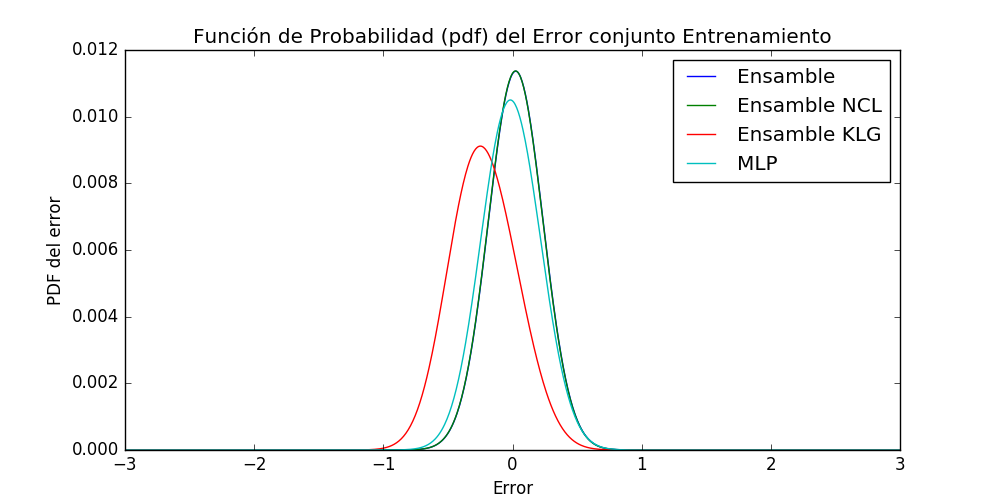

In [55]:
from sklearn.neighbors.kde import KernelDensity

def plot_pdf_error(pred, target, label_plot, ax, fig, n_points=1000, xmin=-3, xmax=3):
    error = pred - target
    N = len(error)
    s = 1.06 * np.std(error) / np.power(N, 0.2)  # Silverman
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2)
    kde.fit(error)
    x_plot = np.linspace(xmin, xmax, n_points)[:, np.newaxis]
    y_plot = np.exp(kde.score_samples(x_plot))
    ax.plot(x_plot, y_plot / np.sum(y_plot), label=label_plot)
    
fig = plt.figure(figsize=(10, 5), dpi=100)
ax = fig.add_subplot(1, 1, 1)

plot_pdf_error(ensemble.predict(X_train), y_train, 'Ensamble', ax, fig)
plot_pdf_error(ensembleNCL.predict(X_train), y_train, 'Ensamble NCL', ax, fig)
plot_pdf_error(ensembleKLG.predict(X_train), y_train, 'Ensamble KLG', ax, fig)
plot_pdf_error(mlp.predict(X_train), y_train, 'MLP', ax, fig)

plt.xlabel('Error')
plt.ylabel('PDF del error');
plt.title("Función de Probabilidad (pdf) del Error conjunto Entrenamiento")
plt.legend()

<IPython.core.display.Javascript object>


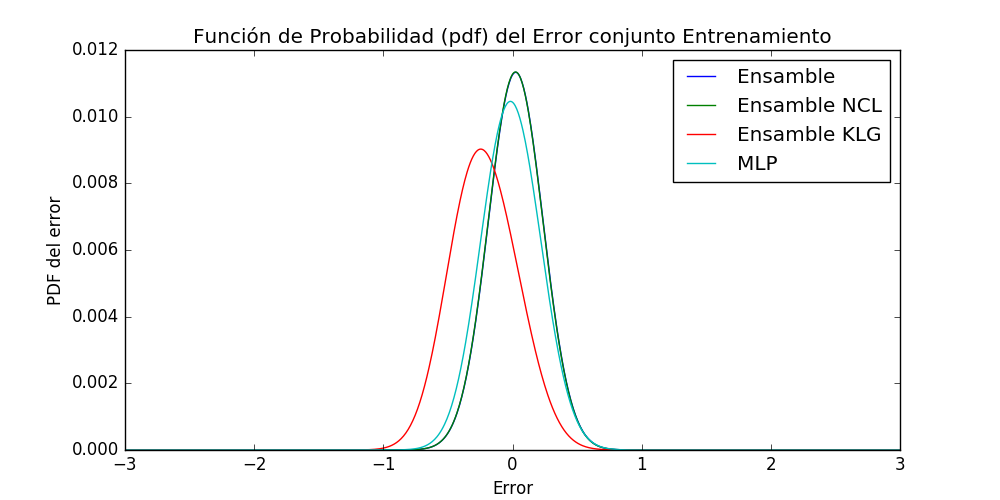

In [56]:
fig = plt.figure(figsize=(10, 5), dpi=100)
ax = fig.add_subplot(1, 1, 1)

plot_pdf_error(ensemble.predict(X_test), y_test, 'Ensamble', ax, fig)
plot_pdf_error(ensembleNCL.predict(X_test), y_test, 'Ensamble NCL', ax, fig)
plot_pdf_error(ensembleKLG.predict(X_test), y_test, 'Ensamble KLG', ax, fig)
plot_pdf_error(mlp.predict(X_test), y_test, 'MLP', ax, fig)

plt.xlabel('Error')
plt.ylabel('PDF del error');
plt.title("Función de Probabilidad (pdf) del Error conjunto Entrenamiento")
plt.legend()

In [57]:
score_test_ensemble = ensemble.score(X_test, y_test)
score_train_ensemble = ensemble.score(X_train, y_train)

score_test_ensembleNCL = ensembleNCL.score(X_test, y_test)
score_train_ensembleNCL = ensembleNCL.score(X_train, y_train)

score_test_ensembleKLG = ensembleKLG.score(X_test, y_test)
score_train_ensembleKLG = ensembleKLG.score(X_train, y_train)

score_test_mlp = mlp.score(X_test, y_test)
score_train_mlp = mlp.score(X_train, y_train)

print('Score RMS')
print('Ensamble: %f / %f' % (score_train_ensemble, score_test_ensemble))
print('Ensamble NCL: %f / %f' % (score_train_ensembleNCL, score_test_ensembleNCL))
print('Ensamble KLG: %f / %f' % (score_train_ensembleKLG, score_test_ensembleKLG))
print('MLP: %f / %f' % (score_train_mlp, score_test_mlp))

Score RMS
Ensamble: 0.005024 / 0.005282
Ensamble NCL: 0.004921 / 0.005156
Ensamble KLG: 0.075869 / 0.075896
MLP: 0.011295 / 0.011624
